# FakeBank Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plotly.express as px
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from time import sleep

%matplotlib inline
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF']) # "#000000" = Black, "#FFFFFF" = White
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow


def score(y_hat, y_test):
  print(f"Testing Accuracy:  {accuracy(y_test, y_hat):0.4f}")
  print(f"Zeros Accuracy:  {accuracy(y_test[y_test ==0], y_hat[y_test==0]):0.4f}")
  print(f"Ones Accuracy:  {accuracy(y_test[y_test==1], y_hat[y_test==1]):0.4f}")


def new_score(y_test,y_hat):
  return ((accuracy(y_test[y_test ==0], y_hat[y_test==0])) + (accuracy(y_test[y_test ==1], y_hat[y_test==1])))

# Accuracy 
def accuracy(y, y_hat):
  return np.mean(y == y_hat)

# Normalize
class MaxMinNormilization():
  def __init__(self, X):
    self.min = np.min(X,0)
    self.max = np.max(X,0)
  def fit(self, X, e = 1e-10):
    X_ = X.copy()
    X_ = (X_ - self.min)/(self.max - self.min + e)
    return X_

# Impute Na's with Median
def Impute_Median(X):
  for col in X.columns:
    if Liver[col].isnull().sum() != 0:
      X[col] = X[col].fillna(X[col].median())

# Confusion Matrix
def Conf_Matrix(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='')
    plt.show()


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# Data Cleaning

In [0]:
def clean_get_data():
  Bank = pd.read_csv('/content/drive/My Drive/DataSets/FakeBank Data/FakeBank_churn.csv')
  Bank_original = pd.read_csv('/content/drive/My Drive/DataSets/FakeBank Data/FakeBank_churn.csv')
  Bank_original.to_numpy()


  # Removing Columns
  Bank.pop('index')
  Bank.pop('Surname')
  Bank.pop('RowNumber')
  Bank.pop('CustomerId')
  # Bank.pop('Gender')

  # Seperating Columns and Normalizing
  Class_Bank = Bank[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Age' ,'Exited']]
  Cont_Bank = Bank[[ 'CreditScore', 'Balance', 'EstimatedSalary']]
  Cont_Bank = Cont_Bank.to_numpy()
  norm = MaxMinNormilization(Cont_Bank) # Normilizing the Continious Data with MaxMin method
  Cont_Bank = norm.fit(Cont_Bank)
  Bank = np.hstack((Cont_Bank, Class_Bank))
  Bank = pd.DataFrame(Bank, columns=['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Age' ,'Exited'])


  # # Sort target values from least to greatest
  Bank = Bank.to_numpy()
  Bank = Bank[np.argsort(Bank[:, -1])] # Oversampling Method: Sorts everything based on Target Value

  # # To Numpy
  y = Bank[:,-1]
  # np.delete(Bank, 0, -1)
  X = Bank[:,0:10]
  tempx = X[7964:,:] # Oversampling Method: Grabs undersampled Target Varibles' rows
  tempy = y[7964:]

  # Remove NA
  X[np.where(X == np.nan)] = 1

  # Converting Female/Male to binary
  X[np.where(X == 'Female')]  = 2
  X[np.where(X == 'Male')]    = 1

  # Converting Country to a value
  X[np.where(X == 'France')]  = 1
  X[np.where(X == 'Germany')] = 2
  X[np.where(X == 'Spain')]   = 3

  # print(np.unique(Bank['Geography'])) # Find all unique country names

  # Converting floats into integers
  X = np.vstack((X,tempx))  # Oversampling Method: Adds the extra Target Rows to the data set
  y = np.hstack((y,tempy))
  X = np.vstack((X,tempx))
  y = np.hstack((y,tempy))
  X = X.astype(int)
  y = y.astype(int)
  return X,y,Bank_original

# Visualization of Data

In [128]:
Bank_original = pd.read_csv('/content/drive/My Drive/DataSets/FakeBank Data/FakeBank_churn.csv')
c_spread = Bank_original[Bank_original['Exited']!=0].groupby('NumOfProducts')['Age'].unique().apply(len)
c_spread = pd.DataFrame(c_spread).reset_index()

fig = px.line(c_spread, x='NumOfProducts', y='Age', text='Age',
              title='Age of Customers who exited and how many products they had with the Bank',
             color_discrete_sequence=[cnf,dth, rec])
fig.update_traces(textposition='top center')
fig.show()

In [0]:
# corr = Bank.corr()
# plt.figure(figsize=(10,10))
# sns.heatmap(corr, annot=True)

In [0]:
# plt.figure()
# plt.scatter(X[:,5], X[:,4])

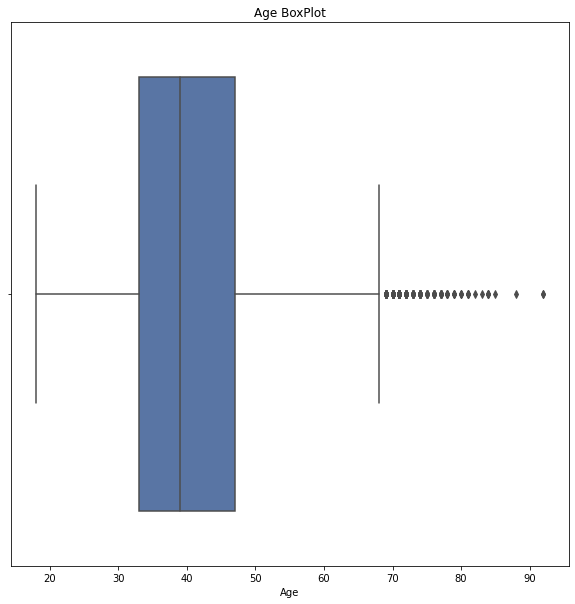

In [5]:
X,y = clean_get_data()
plt.figure(figsize=(10,10))
plt.title('Age BoxPlot')
plt.xlabel('Age')
sns.set(style="whitegrid")
ax = sns.boxplot(X[:,-1])
plt.show()

#### Age of customer and if they exited 

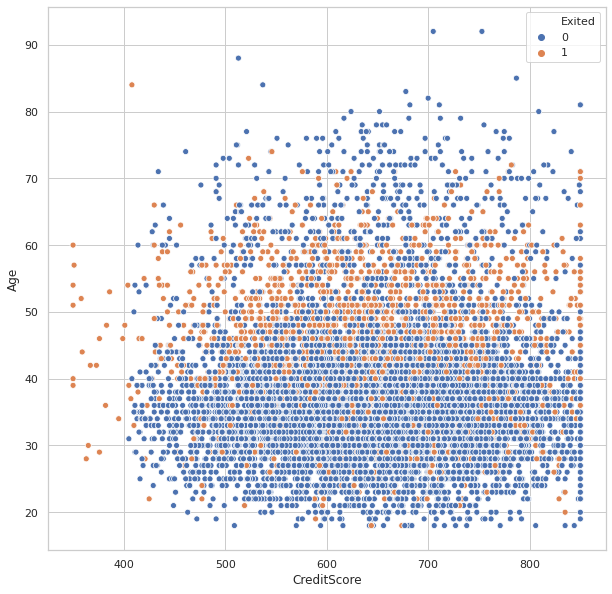

In [41]:
X,y,Bank = clean_get_data()
plt.figure(figsize=(10,10))
plt.xlabel('Age of Customer')
plt.ylabel('Groupings')
sns.scatterplot(x=Bank['CreditScore'],y=Bank['Age'], hue=Bank['Exited'],legend='full')
plt.show()

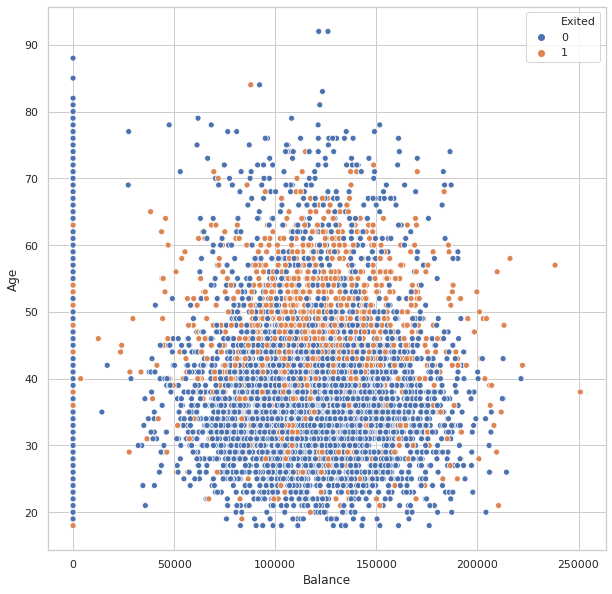

In [42]:
X,y,Bank = clean_get_data()
plt.figure(figsize=(10,10))
plt.xlabel('Age of Customer')
plt.ylabel('Groupings')
sns.scatterplot(x=Bank['Balance'],y=Bank['Age'], hue=Bank['Exited'],legend='full')
plt.show()

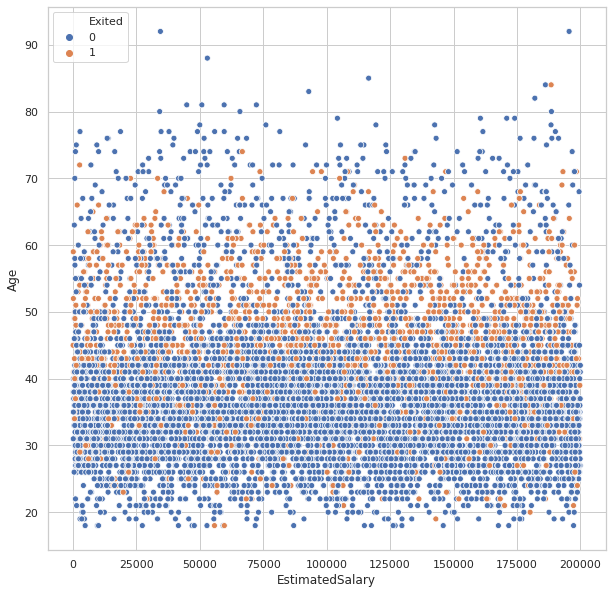

In [43]:
X,y,Bank = clean_get_data()
plt.figure(figsize=(10,10))
plt.xlabel('Age of Customer')
plt.ylabel('Groupings')
sns.scatterplot(x=Bank['EstimatedSalary'],y=Bank['Age'], hue=Bank['Exited'],legend='full')
plt.show()

# Classes

## ANN

### ANN Class Algorthim

In [0]:
# Definitions
def linear(H):
    return H

def ReLU(H):
    return H * (H > 0)

def sigmoid(H):
    return 1/(1 + np.exp(-H))

def tanh(H):
    return np.tanh(H)

def softmax(H):
    eH = np.exp(H)
    return eH/eH.sum(axis = 1, keepdims = True)

def cross_entropy(Y, P_hat):
    return -(1/len(Y)) * np.sum(Y * np.log(P_hat))

def OLS(Y, Y_hat):
    return (1/(2*len(Y))) * np.sum((Y - Y_hat)**2)

def derivatives(Z, a):
    if a == linear:
        return 1
    elif a == sigmoid:
        return Z * (1 - Z)
    elif a == tanh:
        return 1 - Z * Z
    elif a == ReLU:
        return (Z > 0).astype(int)
    else:
        ValuError('Unknown Activation')
        
def one_hot_encode(y):
    N = len(y)      # number of samples
    K = len(set(y)) # number of categories
    Y = np.zeros((N, K))
    for i in range(N):
        Y[i, y[i]] = 1
    return Y

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

#----------------------------------------------------------------------------
# Class
class ANN():
    
    def __init__(self, architecture, activations = None, mode = 0):
        
        self.mode = mode                  # default is for classification
        self.architecture = architecture
        self.L = len(architecture) + 1    # number of layers, include input layer
        self.activations = activations
    
    def fit(self, X, y, lr = 1e-1, epochs = 1000, show_curve = False):
        
        epochs = int(epochs)
        # linear regression or classification
        if self.mode:
            Y = y
        else:
            Y = one_hot_encode(y)
        
        N, D = X.shape # input  layer units: D
        K = Y.shape[1] # output layer units: K
        
        try: # if self.w or self.b is not created it will be created
          self.W # so you can pull out the wieghts and bias
        except AttributeError:          # and place them back into the model
         self.W = {l: np.random.randn(M[0], M[1]) for l, M in enumerate(zip(([D] + self.architecture), (self.architecture + [K])), 1)} # Pull weights out: weights = glr.w
         self.b = {l: np.random.randn(M) for l, M in enumerate(self.architecture + [K], 1)}                                             # Put weights back in: glr.w = weights
        
        
        if self.activations is None:
            self.a = {l: ReLU for l in range(1, self.L)}
        else:
            self.a = {l: act for l, act in enumerate(self.activations, 1)}
        # linear regression or classification
        if self.mode:
            self.a[self.L] = linear
        else:
            self.a[self.L] = softmax
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            
            self.forward(X)
            # save losses
            if self.mode:
                J[epoch] = OLS(Y, self.Z[self.L])
            else:
                J[epoch] = cross_entropy(Y, self.Z[self.L])
            # weights update
            dH = (1/N) * (self.Z[self.L] - Y)
            for l in sorted(self.W.keys(), reverse = True):
                dW = self.Z[l - 1].T@dH
                db = dH.sum(axis = 0)
                self.W[l] -= lr*dW
                self.b[l] -= lr*db
                
                if l > 1:
                    dZ = dH@self.W[l].T
                    dH = dZ*derivatives(self.Z[l - 1], self.a[l - 1])
                    
        if show_curve:
            plt.figure(); plt.plot(J)
            plt.xlabel('epochs'); plt.ylabel('$\mathcal{J}$')
            plt.show()
        
    def forward(self, X):
        self.Z = {0: X}
        
        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l - 1]@self.W[l] + self.b[l])
    
    def predict(self, X):
        self.forward(X)
        
        if self.mode:
            return self.Z[self.L]
        else:
            return self.Z[self.L].argmax(axis = 1)


### ANN percentages

#### Percentages with Training set against itself (without SMOTE)

In [0]:
X,y = clean_get_data()

ann = ANN([64,32,16,8], [tanh, tanh, tanh, tanh])
ann.fit(X, y, lr = 0.1, epochs=100)
weights = ann.W
bias = ann.b

for i in range(100):
  ann = ANN([64,32,16,8], [tanh, tanh, tanh, tanh])
  ann.W = weights
  ann.b = bias
  ann.fit(X, y, lr = 0.01, epochs=10)
  weights = ann.W
  bias = ann.b


y_hat = ann.predict(X)

Conf_Matrix(y,y_hat)

#### Percentages with Testing data set (without SMOTE)

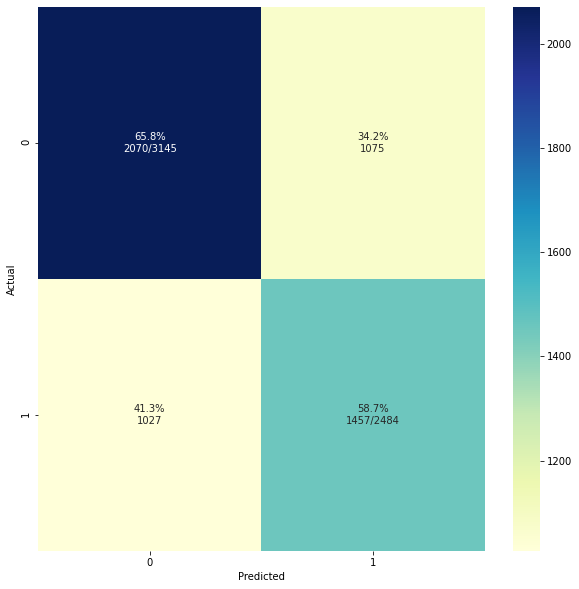

In [13]:
X,y = clean_get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=random.seed(42))

ann = ANN([64,32,16,8], [tanh, tanh, tanh, tanh])
ann.fit(X_train, y_train, lr = 0.1, epochs=1000)
weights = ann.W
bias = ann.b

for i in range(100):
  ann = ANN([64,32,16,8], [tanh, tanh, tanh, tanh])
  ann.W = weights
  ann.b = bias
  ann.fit(X_train, y_train, lr = 0.01, epochs=10)
  weights = ann.W
  bias = ann.b


y_hat = ann.predict(X_test)

Conf_Matrix(y_test,y_hat)

#### Percentages with Training set with SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



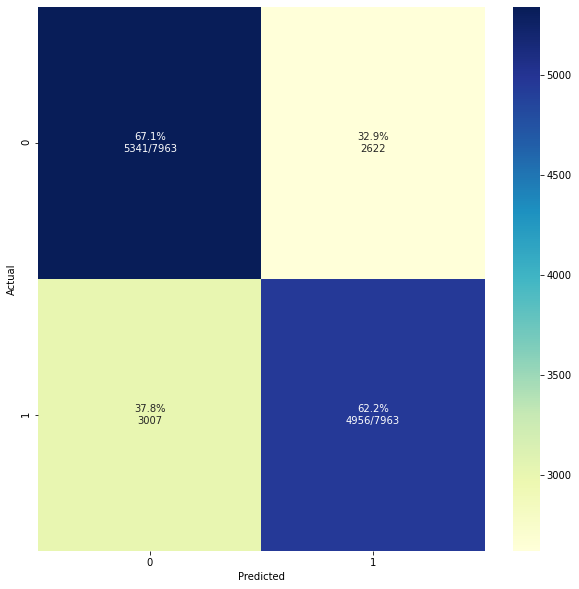

In [14]:
X,y = clean_get_data()

ann = ANN([64,32,16,8], [tanh, tanh, tanh, tanh])
ann.fit(X, y, lr = 0.1, epochs=1000)
weights = ann.W
bias = ann.b

for i in range(100):
  ann = ANN([64,32,16,8], [tanh, tanh, tanh, tanh])
  ann.W = weights
  ann.b = bias
  smote = SMOTE(random_state = i)
  X, y = smote.fit_resample(X, y)
  ann.fit(X, y, lr = 0.01, epochs=10)
  weights = ann.W
  bias = ann.b


y_hat = ann.predict(X)

Conf_Matrix(y,y_hat)

#### Percentages with Testing set with SMOTE

In [0]:
X,y = clean_get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=random.seed(42))

ann = ANN([64,32,16], [tanh, tanh, tanh])
ann.fit(X_train, y_train, lr = 0.1, epochs=1000,show_curve=True)
weights = ann.W
bias = ann.b

for i in range(50):
  ann = ANN([64,32,64], [tanh, tanh, tanh])
  ann.W = weights
  ann.b = bias
  smote = SMOTE(random_state = i)
  X_train, y_train = smote.fit_resample(X_train, y_train)
  ann.fit(X_train, y_train, lr = 0.05, epochs=10)
  weights = ann.W
  bias = ann.b


y_hat = ann.predict(X_test)

Conf_Matrix(y_test,y_hat)

In [0]:

for i in range(10):
  ann = ANN([64,128,64], [tanh, tanh, tanh])
  ann.W = weights
  ann.b = bias
  smote = SMOTE(random_state = i)
  X_train, y_train = smote.fit_resample(X_train, y_train)
  ann.fit(X_train, y_train, lr = 0.0005, epochs=10)
  weights = ann.W
  bias = ann.b


  y_hat = ann.predict(X_test)

  Conf_Matrix(y_test,y_hat)

## ANN Shallow

### ANN Shallow Algorithm

In [0]:
# Definintions
def linear(H):
  return H

def Relu(H):
  return H*(H>0)

def Softmax(H):
  eH = np.exp(H)
  return eH/eH.sum(axis = 1, keepdims = True)

def cross_entropy(Y, P_hat):
  return -np.sum(Y * np.log(P_hat))

def one_hot_encode(y): 
  N = len(y)
  K = len(set(y))
  Y = np.zeros((N,K))

  for i in range(N):
    Y[i,y[i]] = 1
  return Y

def accuracy(y, y_hat):
  return np.mean(y == y_hat)

def OLS(Y, Y_hat):
  return (1/(2*len(Y))) * np.sum((Y-Y_hat)**2)

def R2(y, y_hat):
  return sqrt((y-y_hat)**2)

#-------------------------------------------------------------

# Class
class ANN_shallow():

  def __init__(self, mode = 0):
    self.mode = mode
  
  def fit(self, X, y, neurons = 10, eta = 1e-3, epochs = 1e3, show_curve = False):
    epochs = int(epochs)
    Y = one_hot_encode(y)
    N, D = X.shape
    K = Y.shape[1] 

    try: # if self.w or self.b is not created it will be created
      self.W # so you can pull out the wieghts and bias
    except AttributeError:          # and place them back into the model
      self.W = {l: np.random.randn(M[0], M[1]) for l,M in enumerate( zip([D,neurons], [neurons, K]), 1)} # Pull weights out: weights = glr.w
      self.b = {l: np.random.randn(M) for l,M in enumerate( [neurons,K], 1 )}                            # Put weights back in: glr.w = weights

    if self.mode:
      self.a = {1: np.tanh, 2: linear}
    else: 
      self.a = {1: np.tanh, 2: Softmax}

    J = np.zeros(epochs)

    for epoch in range(epochs):
      self.forward(X)

      if self.mode:
        J[epoch] = OLS(Y, self.Z[2])
      else:
        J[epoch] = cross_entropy(Y, self.Z[2])

      self.W[2] -= eta * (1/N) * self.Z[1].T@(self.Z[2]  - Y)
      self.b[2] -= eta * (1/N) * (self.Z[2] - Y).sum(axis = 0)
      
      self.W[1] -= eta * (1/N) * X.T@((self.Z[2] - Y)@self.W[2].T * (1-self.Z[1]**2))
      self.b[1] -= eta * (1/N) * ((self.Z[2] - Y)@self.W[2].T*(1-self.Z[1]**2)  ).sum(axis = 0)

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel('epochs')
      plt.ylabel('J')
      plt.show()

  def forward(self, X):
    self.Z = {0: X}

    for l in sorted(self.W.keys()):
      self.Z[l] = self.a[l](self.Z[l-1]@self.W[l] + self.b[l])

  def predict(self, X):
    self.forward(X)

    if self.mode:
      return self.Z[2]
    else:
      return self.Z[2].argmax(axis = 1)


### ANN Shallow Tests

#### Percentages with Training set against itself

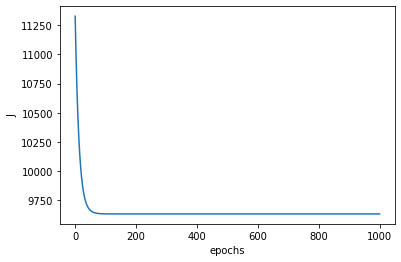

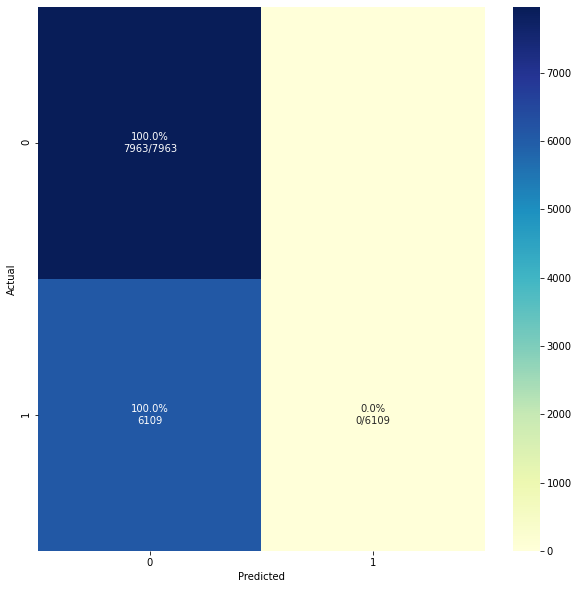

In [18]:
X,y = clean_get_data()

anns = ANN_shallow()
anns.fit(X, y, neurons = 7, eta = 0.01, epochs=1000, show_curve = True)
weights = anns.W
bias = anns.b
y_hat = anns.predict(X)

for i in range(100):
  anns = ANN_shallow()
  anns.W = weights
  anns.b = bias
  anns.fit(X, y, neurons = 7, eta = 0.001, epochs=10)
  y_hat = anns.predict(X)
  weights = anns.W
  bias = anns.b

y_hat = anns.predict(X)

Conf_Matrix(y,y_hat)

#### Percentages with Testing set (no noise/SMOTE)


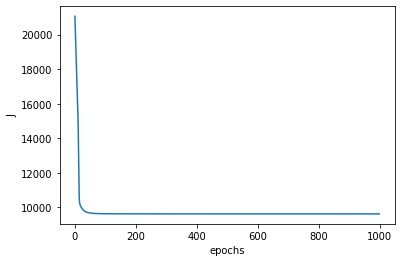

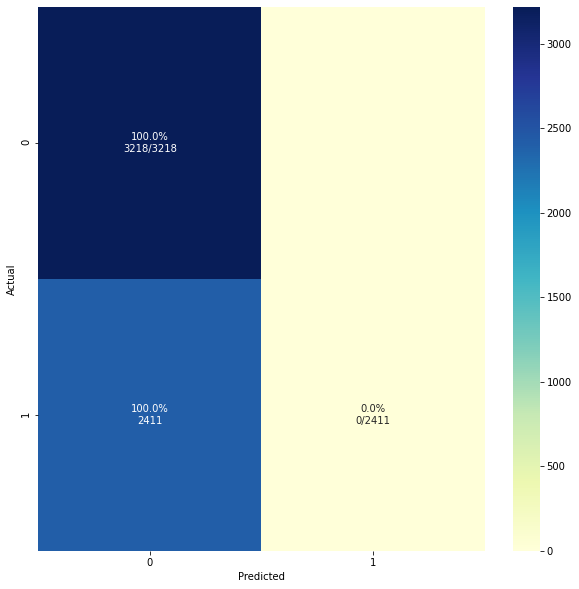

In [19]:
X,y = clean_get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random.seed(42))
anns = ANN_shallow()
anns.fit(X, y, neurons = 7, eta = 0.01, epochs=1000, show_curve = True)
weights = anns.W
bias = anns.b
y_hat = anns.predict(X_test)
Percentage = new_score(y_test,y_hat)

for i in range(100):
  anns = ANN_shallow()
  anns.W = weights
  anns.b = bias
  anns.fit(X, y, neurons = 7, eta = 0.001, epochs=10)
  y_hat = anns.predict(X)
  weights = anns.W
  bias = anns.b

y_hat = anns.predict(X_test)

Conf_Matrix(y_test,y_hat)

#### Percentages with Training set with itself and SMOTE

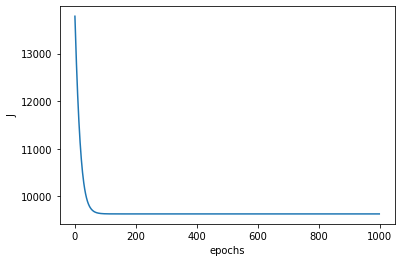

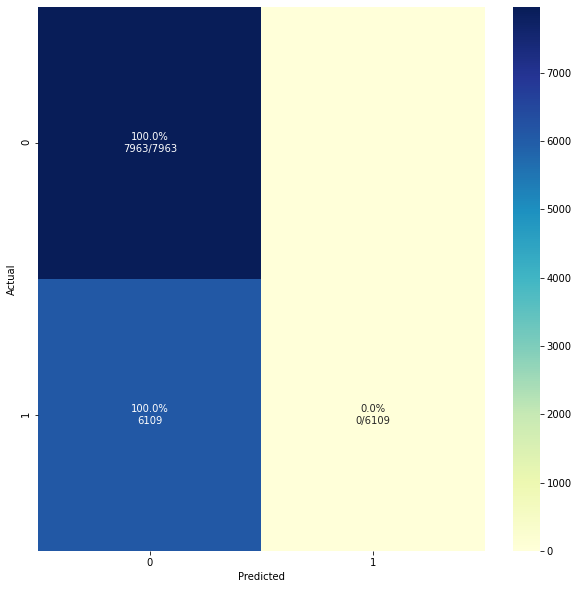

In [20]:
X,y = clean_get_data()

anns = ANN_shallow()
anns.fit(X, y, neurons = 7, eta = 0.01, epochs=1000, show_curve = True)
weights = anns.W
bias = anns.b
y_hat = anns.predict(X)

for i in range(100):
  anns = ANN_shallow()
  anns.W = weights
  anns.b = bias
  anns.fit(X, y, neurons = 7, eta = 0.001, epochs=10)
  y_hat = anns.predict(X)
  weights = anns.W
  bias = anns.b

y_hat = anns.predict(X)

Conf_Matrix(y,y_hat)

#### Percentage with Testing dataset with SMOTE

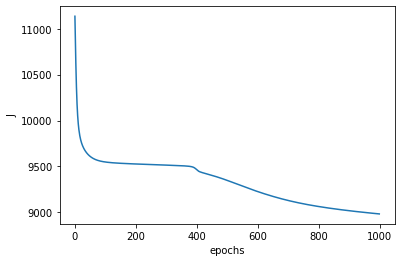

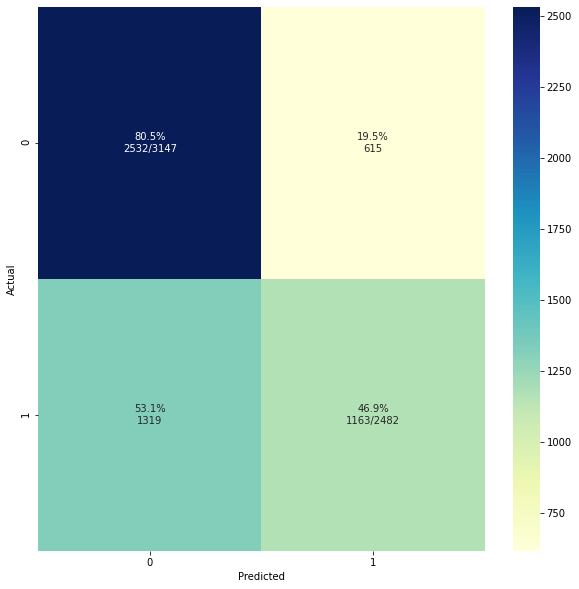

In [21]:
X,y = clean_get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random.seed(42))

anns = ANN_shallow()
anns.fit(X, y, neurons = 7, eta = 0.01, epochs=1000, show_curve = True)
weights = anns.W
bias = anns.b
y_hat = anns.predict(X_test)
Percentage = new_score(y_test,y_hat)

for i in range(100):
  anns = ANN_shallow()
  anns.W = weights
  anns.b = bias
  anns.fit(X, y, neurons = 7, eta = 0.001, epochs=10)
  y_hat = anns.predict(X)
  weights = anns.W
  bias = anns.b

y_hat = anns.predict(X_test)

Conf_Matrix(y_test,y_hat)

## Logistic Regression 

### Functions/Definitions

In [0]:
def softmax(h):
  return (np.exp(h.T) / np.sum(np.exp(h), axis = 1)).T

# Multivariate
def cross_entropy(y, P_hat):
  return -(1/len(y)) * np.sum(np.sum(y*np.log(P_hat), axis = 1), axis = 0)

def indices_to_one_hot(data, nb_classes):
  # 
 targets = np.array(data).reshape(-1)
 return np.eye(nb_classes)[targets]


def accuracy(y, y_hat):
  return np.mean(y == y_hat)

### Class

In [0]:
class GenLogisticRegression():

  def _init_(self, thresh=0.5):
    self.w = None
    self.b = None

  def fit(self, X, Y, eta = 2e-2, epochs = 1e3, show_curve = False):
    N, D = X.shape # N is the number of observations, D is the number of Dimensions
    epochs = int(epochs)
    K = len(np.unique(Y))

    Y = indices_to_one_hot(Y,K).astype(int)
    try:
      self.w
    except AttributeError:
      self.w = np.random.randn(D,K)
      self.b = np.random.randn(K)
    

    J = np.zeros(int(epochs))

    for epoch in range(epochs):
      P_hat = self._forward_(X)
      J[epoch] = cross_entropy(Y, P_hat)
      self.w -= eta*(1/N)*X.T@(P_hat - Y)
      self.b -= eta*(1/N)*np.sum(P_hat - Y, axis=0)

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("J")
      plt.title("Training Curve")
      plt.show()

  def _forward_(self, X):
      # print('X Shape: ' + str(X.shape))
      # print('w Shape: ' + str(self.w.shape))
      # print('b Shape: ' + str(self.b.shape))
      return softmax(X@self.w + self.b)

  def predict(self,X):
      return np.argmax(self._forward_(X), axis=1)


### Percentages and Accuracy

#### Precentages with Training set without SMOTE

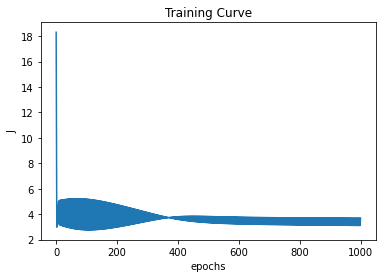

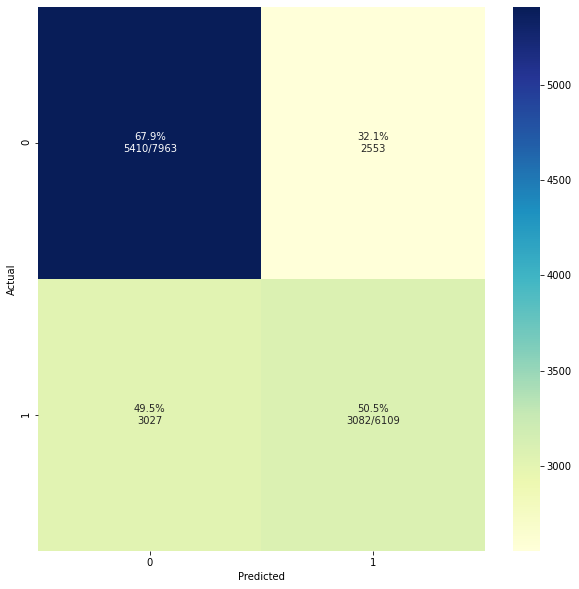

In [24]:
X,y = clean_get_data()

glr = GenLogisticRegression()
glr.fit(X, y, eta = 0.01, epochs=1000, show_curve = True)
weights = glr.w
bias = glr.b

for i in range(100):
  glr = GenLogisticRegression()
  glr.w = weights
  glr.b = bias
  glr.fit(X, y, eta = 0.001, epochs=10)
  weights = glr.w
  bias = glr.b


y_hat = glr.predict(X)

Conf_Matrix(y,y_hat)

#### Precentages with Testing set without SMOTE

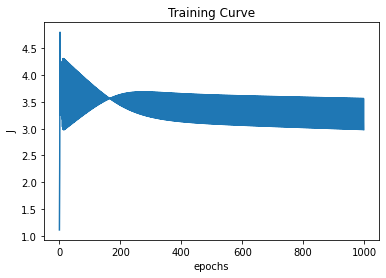

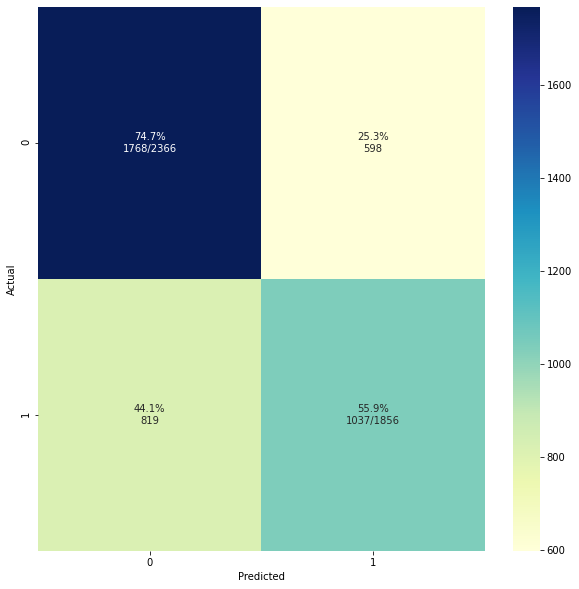

In [25]:
X,y = clean_get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.seed(42))

glr = GenLogisticRegression()
glr.fit(X_train, y_train, eta = 0.01, epochs=1000, show_curve = True)
weights = glr.w
bias = glr.b

for i in range(100):
  glr = GenLogisticRegression()
  glr.w = weights
  glr.b = bias
  glr.fit(X_train, y_train, eta = 0.001, epochs=10)
  weights = glr.w
  bias = glr.b


y_hat = glr.predict(X_test)

Conf_Matrix(y_test,y_hat)

#### Precentages with Training set and SMOTE

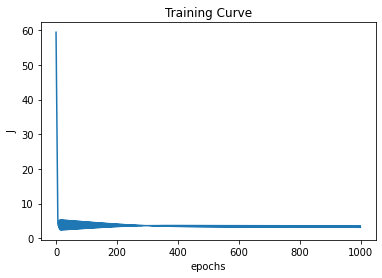

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



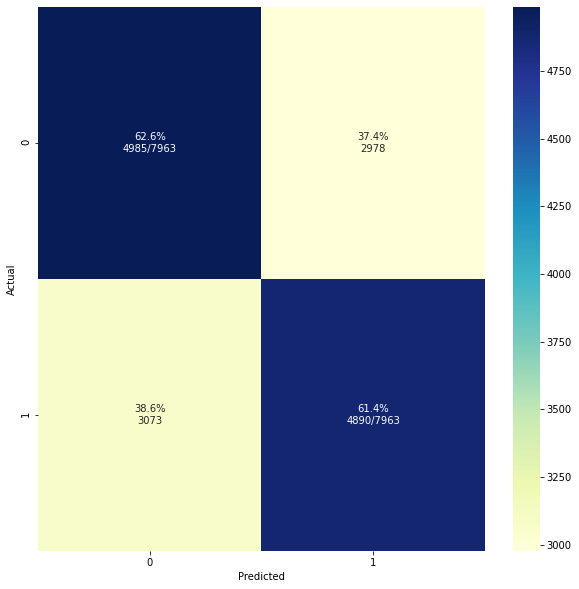

In [26]:
X,y = clean_get_data()

glr = GenLogisticRegression()
glr.fit(X, y, eta = 0.01, epochs=1000, show_curve = True)
weights = glr.w
bias = glr.b

for i in range(100):
  glr = GenLogisticRegression()
  glr.w = weights
  glr.b = bias
  smote = SMOTE(random_state = i)
  X, y = smote.fit_resample(X, y)
  glr.fit(X, y, eta = 0.001, epochs=10)
  weights = glr.w
  bias = glr.b


y_hat = glr.predict(X)

Conf_Matrix(y,y_hat)

#### Precentages with Testing set and SMOTE (and extra noise)

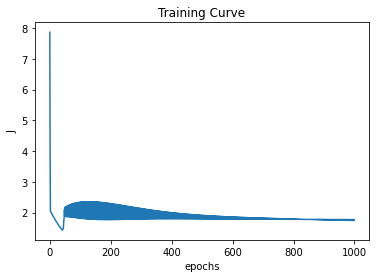

(9850, 10)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



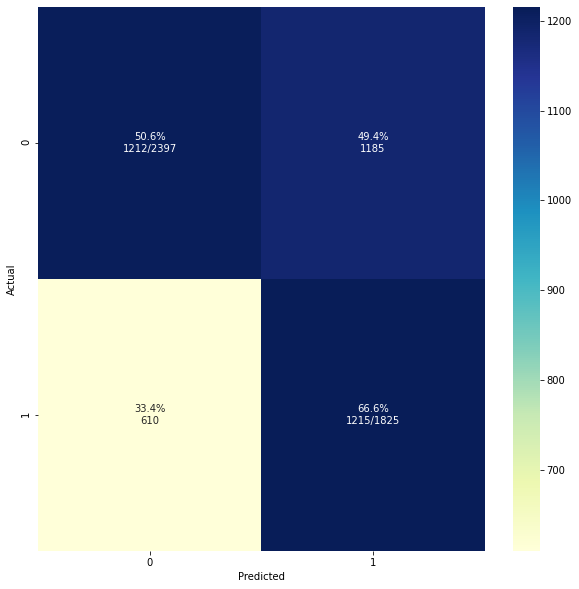

In [27]:
X,y = clean_get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.seed(42))
glr = GenLogisticRegression()
glr.fit(X_train, y_train, eta = 0.005, epochs=1000, show_curve = True)
weights = glr.w
bias = glr.b

print(X_train.shape)
for i in range(1000):
  glr = GenLogisticRegression()
  glr.w = weights
  glr.b = bias
  smote = SMOTE(random_state = i)
  X_train, y_train = smote.fit_resample(X_train, y_train)
  # N,D = X_train.shape
  # noise = np.random.randn(N,D)* 0.01
  # X_train = X_train + noise
  glr.fit(X_train, y_train, eta = 0.001, epochs=10)
  weights = glr.w
  bias = glr.b


y_hat = glr.predict(X_test)

Conf_Matrix(y_test,y_hat)

##### Save Weights and Bias

In [0]:
np.savetxt('FakeBank_weights.csv', weights, delimiter=',')
np.savetxt('FakeBank_bias.csv', bias, delimiter=',')


# Pytorch 

## Two Layer 

In [0]:
import numpy as np
import pandas as pd
import torch

class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):

    super(TwoLayerNet, self).__init__() # Super delcarlation
    self.linear1 = torch.nn.Linear(D_in, H)  # iniates the first inner layer
    self.linear2 = torch.nn.Linear(H, D_out) # iniates the second inner layer
  
  def forward(self, X):
    h_relu = self.linear1(X).clamp(min = 0)
    y_hat = self.linear2(h_relu) # acts on layers one after another

    return y_hat
  

torch.Size([14072, 10])
torch.Size([14072, 1])
0 14601.83203125


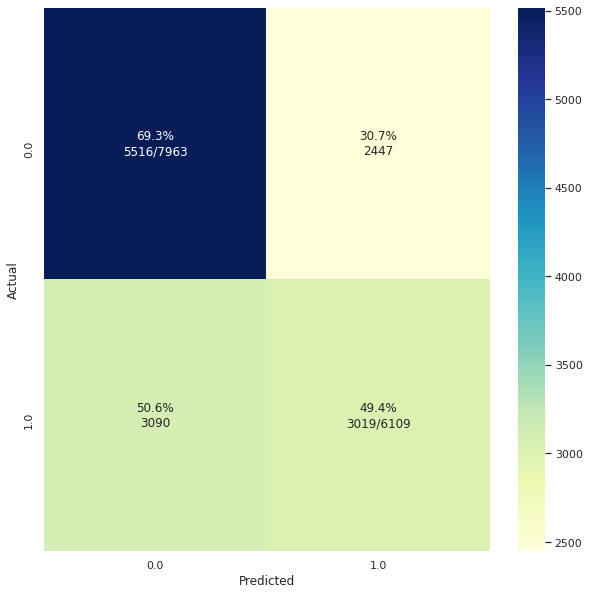

In [188]:
X,y = clean_get_data()
y = y.reshape((len(y), 1))

D_in = 10 # Dimensions out
D_out = 1 # Dimenions must match the ones with y 
H  = 50 # H is the number of hidden nodes


torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)
X = torch_X.float()
y = torch_y.float()
print(X.shape)
print(y.shape)


model = TwoLayerNet(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-11)  # an optimizer (Scholatic Gradient Descent)

epochs = 50000

for epoch in range(epochs):
  y_hat = model(X) # will effectively run forward method

  loss = criterion(y_hat, y)

  if epoch % 5000 == 0:
    print(epoch, loss.item())
  
  optimizer.zero_grad()
  loss.backward() # Backward propagation
  optimizer.step()

y_hat = y_hat.round()
y_hat = y_hat.data.cpu().numpy()
y = y.data.cpu().numpy()

Conf_Matrix(y,y_hat)

## Layers

In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as pyplot


class Layer(torch.nn.Module):
  def __init__(self, size_in, size_out, activation):
    super(Layer, self).__init__()
    self.weights = torch.nn.Parameter(torch.randn(size_in, size_out, requires_grad=True))
    self.bias = torch.nn.Parameter(torch.randn(1,size_out,requires_grad = True))
    self.activation = activation

  def Forward(self, z_in):
    return self.activation(z_in @ self.weights + self.bias)

In [225]:
X,y = clean_get_data()
y = y.reshape((len(y), 1))

D_in = 10 # Dimensions out
D_out = 1 # Dimenions must match the ones with y 
H  = 200 # H is the number of hidden nodes


torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)
X = torch_X.float()
y = torch_y.float()
print(X.shape)
print(y.shape)


## Intiliaze Layer
forget = Layer(10, 14072, torch.nn.Sigmoid())
loss_func = torch.nn.MSELoss()
opt = torch.optim.Adam(forget.parameters()) 

torch.Size([14072, 10])
torch.Size([14072, 1])


In [0]:
# print(forget.bias)
# out= forget.Forward(X)
# loss = loss_func(out, y)
# loss.backward()
# opt.step()
# opt.zero_grad()
# print(forget.bias)

# y_hat = y_hat.round()
# y_hat = y_hat.data.cpu().numpy()
# y = y.data.cpu().numpy()

# Conf_Matrix(y,y_hat)

# RNN

In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as pyplot


class RNN(torch.nn.Module):
  def __init__(self, size_in, size_out, size_mem):
    super(RNN, self).__init__()
    self.size_mem =size_mem
    self.mem_layer = Layer(size_in + size_mem, size_mem, torch.tanh)
    self.out_layer = Layer(size_mem, size_out,torch.sigmoid)

  def Forward(self, x):
    mem = torch.zeros(1, self.size_mem)
    y_hat=[]
    for i in range (x.shape[0]):
      x_in = x[[i], :]
      z_in = torch.cat([x_in, mem], dim =1)
      mem = self.mem_layer.Forward(z_in)
      y_hat.append(self.out_layer.Forward(mem))
    return torch.cat(y_hat, dim=0)


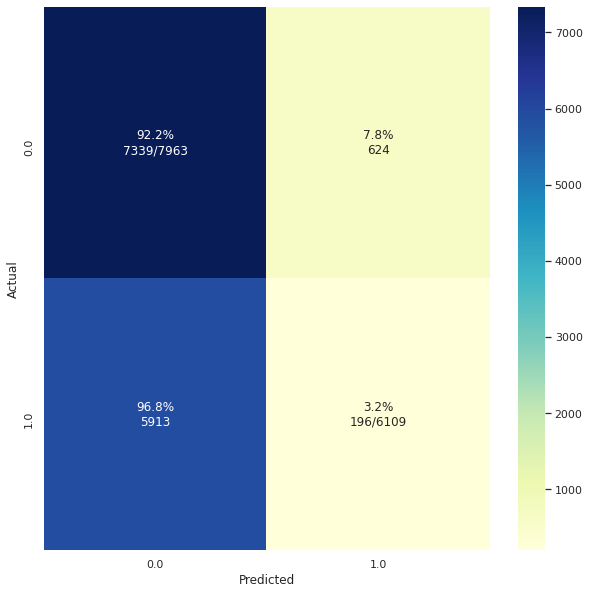

In [221]:
X,y = clean_get_data()
y = y.reshape((len(y), 1))

D_in = 10 # Dimensions out
D_out = 1 # Dimenions must match the ones with y 



torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)
X = torch_X.float()
y = torch_y.float()


rnn = RNN(D_in, D_out, 2000)
loss_func = torch.nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters())


# print(rnn.mem_layer.bias)
y_hat = rnn.Forward(X)
loss = loss_func(y_hat, y)
loss.backward()
opt.step()
opt.zero_grad()
# print()
# print(rnn.mem_layer.bias)


y_hat = y_hat.round()
y_hat = y_hat.data.cpu().numpy()
y = y.data.cpu().numpy()

Conf_Matrix(y,y_hat)